# 🔬 Correlation Between Bulk and Single-Cell Embeddings

This notebook evaluates how similar bulk and single-cell model-derived embeddings are for the same cell lines, using cosine similarity and correlation metrics.


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load bulk embeddings (.npy) and matching SANGER_MODEL_IDs
bulk_embeddings = np.load("../../bulk_state_of_the_art/data/embeddings/bulk_embeddings.npy")
bulk_ids = pd.read_csv("../../bulk_state_of_the_art/data/bulk/processed_bulk.csv")["SANGER_MODEL_ID"].tolist()

# Load SC pseudo-bulk embeddings from CSV (with index column)
sc_df = pd.read_csv("embeddings/pseudobulk_sc_embeddings_aligned.csv", index_col=0)

print("✅ Loaded:")
print(f"Bulk: {bulk_embeddings.shape} | Bulk IDs: {len(bulk_ids)}")
print(f"SC shape: {sc_df.shape}")


✅ Loaded:
Bulk: (1431, 3072) | Bulk IDs: 1431
SC shape: (140, 3072)


In [4]:
# Build DataFrame for bulk
bulk_df = pd.DataFrame(bulk_embeddings, index=bulk_ids)

# Find intersection of shared IDs
shared_ids = sorted(set(bulk_df.index) & set(sc_df.index))
print(f"✅ Shared cell lines: {len(shared_ids)}")

# Align both DataFrames to shared IDs
bulk_filtered = bulk_df.loc[shared_ids].sort_index()
sc_filtered = sc_df.loc[shared_ids].sort_index()

# Sanity check
assert bulk_filtered.shape == sc_filtered.shape, "❌ Shape mismatch after alignment"
print("✅ Filtered shapes match:", bulk_filtered.shape)


✅ Shared cell lines: 140
✅ Filtered shapes match: (140, 3072)


In [5]:
cosine_scores = []
pearson_scores = []

for i in range(len(shared_ids)):
    b = bulk_filtered.iloc[i].values
    s = sc_filtered.iloc[i].values

    cosine = cosine_similarity([b], [s])[0, 0]
    pearson, _ = pearsonr(b, s)

    cosine_scores.append(cosine)
    pearson_scores.append(pearson)

corr_df = pd.DataFrame({
    "SANGER_MODEL_ID": shared_ids,
    "cosine_similarity": cosine_scores,
    "pearson_correlation": pearson_scores
})

print("✅ Correlation results:")
print(corr_df.describe())


✅ Correlation results:
       cosine_similarity  pearson_correlation
count         140.000000           140.000000
mean            0.555712             0.539818
std             0.044026             0.044714
min             0.392679             0.377784
25%             0.542765             0.525713
50%             0.564609             0.548283
75%             0.582864             0.567710
max             0.636897             0.622056


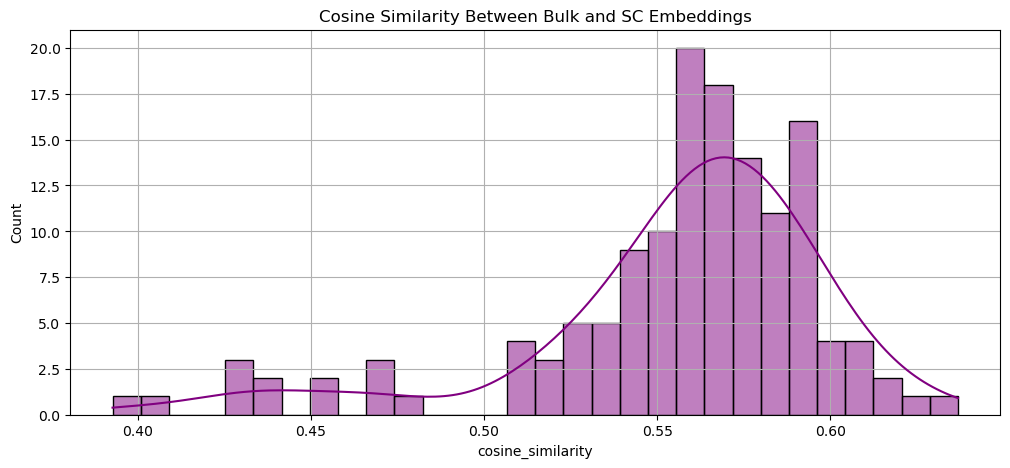

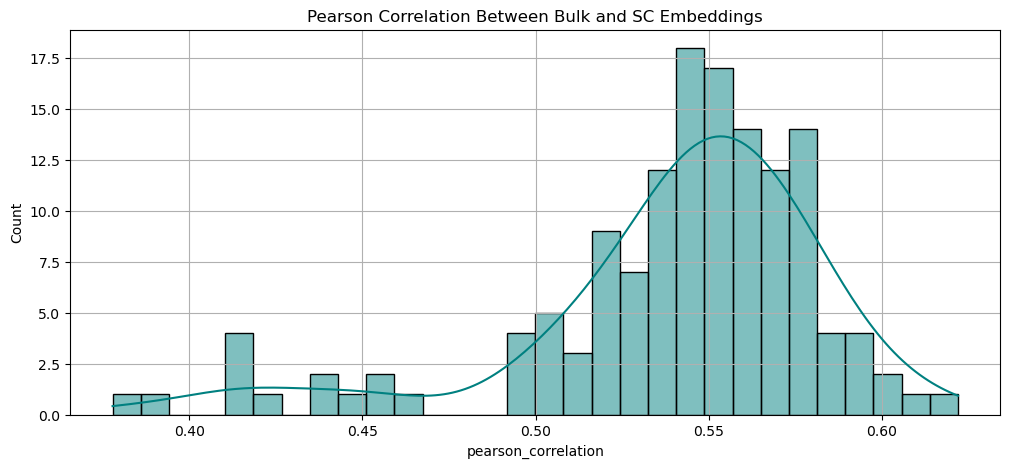

In [6]:
plt.figure(figsize=(12, 5))
sns.histplot(corr_df["cosine_similarity"], bins=30, color="purple", kde=True)
plt.title("Cosine Similarity Between Bulk and SC Embeddings")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(corr_df["pearson_correlation"], bins=30, color="teal", kde=True)
plt.title("Pearson Correlation Between Bulk and SC Embeddings")
plt.grid(True)
plt.show()


NaNs in bulk: 0
NaNs in SC: 0
Any NaNs after concat? 0


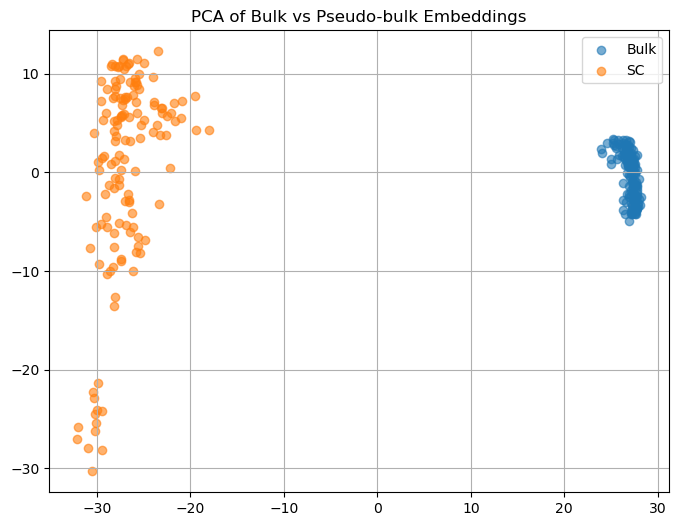

In [7]:
print("NaNs in bulk:", bulk_filtered.isna().sum().sum())
print("NaNs in SC:", sc_filtered.isna().sum().sum())

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reset column names to integers so they align
bulk_fixed = bulk_filtered.copy()
sc_fixed = sc_filtered.copy()

bulk_fixed.columns = range(bulk_fixed.shape[1])
sc_fixed.columns = range(sc_fixed.shape[1])

# Concatenate
X = pd.concat([bulk_fixed, sc_fixed])
labels = ['bulk'] * len(bulk_fixed) + ['sc'] * len(sc_fixed)

# Sanity check
print("Any NaNs after concat?", X.isna().sum().sum())


pca = PCA(n_components=2)
proj = pca.fit_transform(X)


plt.figure(figsize=(8, 6))
plt.scatter(proj[:len(bulk_filtered), 0], proj[:len(bulk_filtered), 1], label="Bulk", alpha=0.6)
plt.scatter(proj[len(bulk_filtered):, 0], proj[len(bulk_filtered):, 1], label="SC", alpha=0.6)
plt.title("PCA of Bulk vs Pseudo-bulk Embeddings")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from scipy.stats import spearmanr

spearman_scores = []
for i in range(len(shared_ids)):
    b = bulk_filtered.iloc[i].values
    s = sc_filtered.iloc[i].values
    spearman, _ = spearmanr(b, s)
    spearman_scores.append(spearman)


In [9]:
from scipy.spatial import procrustes

m1, m2, disparity = procrustes(bulk_filtered.values, sc_filtered.values)
print("Procrustes disparity:", disparity)


Procrustes disparity: 0.4641492992721966


In [10]:
# Copy filtered bulk embeddings and reset index
bulk_aligned_df = bulk_filtered.copy()
bulk_aligned_df.insert(0, "SANGER_MODEL_ID", bulk_aligned_df.index)

# Save to CSV
bulk_output_path = "embeddings/bulk_embeddings_aligned_to_sc.csv"
bulk_aligned_df.to_csv(bulk_output_path, index=False)

print(f"✅ Aligned bulk embeddings saved to: {bulk_output_path}")
print("📌 Shape:", bulk_aligned_df.shape)
print(bulk_aligned_df.head())

✅ Aligned bulk embeddings saved to: embeddings/bulk_embeddings_aligned_to_sc.csv
📌 Shape: (140, 3073)
          SANGER_MODEL_ID         0         1         2         3         4  \
SIDM00078       SIDM00078 -0.706589  2.698823  0.199503  0.945463 -1.015511   
SIDM00080       SIDM00080 -1.107486  2.812897  0.598948  1.166040 -1.334981   
SIDM00082       SIDM00082 -0.861736  2.695292  0.572739  1.265256 -1.349733   
SIDM00088       SIDM00088 -1.016777  2.669602  0.360219  1.171151 -1.147132   
SIDM00092       SIDM00092 -1.024238  2.654351  0.317951  1.110101 -1.042873   

                  5         6         7         8  ...      3062      3063  \
SIDM00078  0.459263  0.652819 -0.905401  0.264180  ... -0.038278 -0.459319   
SIDM00080  0.158415  1.096316 -0.520834  0.154155  ...  0.528237 -0.421322   
SIDM00082  0.068901  1.030786 -0.510589  0.135682  ...  0.539548 -0.263760   
SIDM00088  0.201590  0.952294 -0.919201  0.119398  ...  0.412836 -0.139437   
SIDM00092  0.077642  0.873020 -0.